In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output


In [3]:
# This function works with both dbtable and the catalog header name on EDD
def get_catal(catal_string, infoFile="../bar_files/catalogs_info.dat", bars_folder='../bar_files/'):
    
    xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.", verbose=True)

    with open(infoFile, "r") as f:
        lines = f.readlines()


        try:
            for i, line in enumerate(lines):
                if catal_string in line:
                    
                    while not "begin" in line:
                        i-=1
                        line = lines[i]
                    while not "filename" in line:
                        i+=1
                        line=lines[i]

                    fname_string = line
                    break
        except: 
            return "", []
            
        catal_columns = []
        
        try:
            while not "column" in line:
                i+=1
                line=lines[i]
            while not 'end' in line:
                catal_columns.append(line.split("=>")[1].split("|")[0].strip())
                i+=1
                line=lines[i]
                
        except:
            print("why")
            return "", []


    catal_file_name = fname_string.split("=>")[1].strip("\n").strip("")
    
    xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/"+catal_file_name+"  "+bars_folder+"/.", verbose=True)
    
    data = pd.read_csv(bars_folder+catal_file_name, names=catal_columns, delimiter='|')
    
    for col in catal_columns:
        if col.upper()=="PGC":
            break
    
    data.rename(columns={col:col.upper()}, inplace=True)
    data = data.set_index('PGC')
    
    # taking care of empty string
    data = data.replace(r'^\s*$', np.nan, regex=True)
    
    if "1PGC" in data.columns:
        data = data.rename(columns={"1PGC": "PGC1"})
    else:
        data["PGC1"] = data.index.values
    
    if "av_flag" in data.columns:
        data = data[data.av_flag==0]
    
    
    return data

In [49]:
def make_data(data, catalogs, catal_data, catal_key, catal_DM="DM", catal_eDM="eDM", delta=0, \
              cols=["Vcmb","Nest"]):
    
    if not catal_key in catalogs and not catal_key in data:
        data[catal_key] = catal_data[["PGC1", catal_DM, catal_eDM]+cols]
        data[catal_key] = data[catal_key].rename(columns={"PGC1": "PGC1_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_DM: "DM_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_eDM: "eDM_"+catal_key})
        
        for col in cols:
            data[catal_key] = data[catal_key].rename(columns={col: col+"_"+catal_key})
        
        catalogs.append(catal_key)
        
        data[catal_key]["DM_"+catal_key] += delta
        
    else:
        print("This catalog has been already imported ...")
        print("Use a different key than "+catal_key)
    
    return data, catalogs
    

In [50]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [51]:
# !scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files ../.

In [52]:
# !scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

In [53]:
data = {}
catalogs = []

In [54]:
catal_dbtable = "k6dfgsrev"
catal = get_catal(catal_dbtable)

catal  = catal[catal['rej']==0]

data, catalogs = make_data(data, catalogs, catal, "6dfgs", catal_DM="DM75", catal_eDM="eDM")
catal.head()


scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/6dFGSv_recal_bar  ../bar_files//.


,rej,PGC1,Nest,Name,Vcmb,Vgp,D75,D100,feD,DM75,DM100,eDM,RA,DE,Vg,Gp
PGC,,,,,,,,,,,,,,,,
64,0,72642,200033,g0000523-355037,15324,14646,219.3,164.5,0.29,36.705,36.080,0.551,0.2181,-35.8437,1261,NaN
66,0,72642,200033,g0000532-355911,14725,14646,188.7,141.5,0.27,36.379,35.754,0.519,0.2216,-35.9863,1261,NaN
114,0,72642,200033,g0001341-361900,14397,14397,132.1,99.0,0.27,35.604,34.979,0.526,0.3923,-36.3167,-1,NaN
115,0,115,0,g0001453-042049,14005,14005,186.5,139.8,0.27,36.353,35.728,0.517,0.4387,-4.3469,-1,NaN
123,0,123,205549,g0001361-144455,10966,10966,158.8,119.1,0.26,36.004,35.379,0.498,0.4002,-14.7487,-1,NaN


In [55]:
print(len(data["6dfgs"]))
data["6dfgs"]

7112


,PGC1_6dfgs,DM_6dfgs,eDM_6dfgs,Vcmb_6dfgs,Nest_6dfgs
PGC,,,,,
64,72642,36.705,0.551,15324,200033
66,72642,36.379,0.519,14725,200033
114,72642,35.604,0.526,14397,200033
115,115,36.353,0.517,14005,0
123,123,36.004,0.498,10966,205549
...,...,...,...,...,...
4684754,4684754,34.449,0.556,6624,210660
4684803,4684803,35.914,0.512,9189,208156
4684804,4684804,34.731,0.607,9163,208117


In [101]:
catal_dbtable = "ksdssfpdistvpub"
catal = get_catal(catal_dbtable)
catal = catal.rename(columns={"czcmb": "Vcmb"})
data, catalogs = make_data(data, catalogs, catal, "fpsdss", catal_DM="DMc75", catal_eDM="eDM")
catal.head()


scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/sdss_fp_distances_pub_bar  ../bar_files//.
This catalog has been already imported ...
Use a different key than fpsdss


,Dc75,DMc75,Dc100,DMc100,eDMc,DM100,eDM,logDc,elogDc,skewc,...,r,er,i,ei,s,es,Sn,objid,specid,plate
PGC,,,,,,,,,,,,,,,,,,,,,
20919,204.0,36.548,153.0,35.923,0.458,35.936,0.498,0.040675,0.091698,-0.541032,...,0.55667,0.00434,2.65845,0.00873,2.46123,0.00775,1.0000,1237663547968323716,1951253584033114112,1733
21014,62.6,33.981,46.9,33.356,0.497,33.315,0.508,-0.156026,0.099438,0.076115,...,0.15331,0.00320,2.69511,0.00643,2.30353,0.00511,0.3231,1237663917871988832,2099918005914855936,1865
21072,196.7,36.470,147.6,35.845,0.458,35.858,0.496,0.025511,0.091508,-0.538911,...,0.57642,0.00381,2.63590,0.00767,2.47846,0.00755,1.0000,1237663531326243079,1951295365474969600,1733
21226,208.7,36.597,156.5,35.973,0.488,35.999,0.497,0.034595,0.097532,-0.675872,...,0.47205,0.00345,2.73040,0.00696,2.44156,0.00485,1.0000,1237653588476952852,609190772427745280,541
21473,173.1,36.192,129.8,35.567,0.500,35.584,0.495,-0.023480,0.099913,-0.619854,...,0.70569,0.00368,2.12132,0.00742,2.28253,0.01174,1.0000,1237657595682029975,848939837200295808,754


In [104]:
catal.loc[2180626]

Dc75                    100.9
DMc75                  35.019
Dc100                    75.7
DMc100                 34.395
eDMc                    0.468
DM100                  34.299
eDM                     0.479
logDc                0.027767
elogDc               0.093567
skewc               -0.349573
logD                 0.046916
elogD                0.095898
skew                -0.375417
czh                      7871
eczh                        2
Vcmb                     7909
gczcmb                   7909
Nest                        0
PGC1                        0
IDt17                       0
Ngt17                       1
J2000       J161531.4+412425 
Ra                   243.8807
Dec                    41.407
glon                  65.5758
glat                   46.177
sgl                   71.4499
sgb                   47.1549
gmag                   15.442
egmag                   0.003
rmag                   14.653
ermag                   0.002
rad                     2.732
erad      

In [97]:
print(len(data["fpsdss"]))
data["fpsdss"]

34059


,PGC1_fpsdss,DM_fpsdss,eDM_fpsdss,Vcmb_fpsdss,Nest_fpsdss
PGC,,,,,
20919,20919,36.548,0.498,16184,104087
21014,21014,33.981,0.508,3250,111419
21072,21072,36.470,0.496,14984,104427
21226,21226,36.597,0.497,16290,101391
21473,21493,36.192,0.495,11962,105529
...,...,...,...,...,...
5094035,0,37.500,0.517,29916,0
5094400,52870,36.869,0.499,12259,105205
5094420,3762668,38.803,0.535,22133,0


In [98]:
fp_sdss = data["fpsdss"]

In [100]:
fp_sdss.loc[2180626]

PGC1_fpsdss       0.000
DM_fpsdss        35.019
eDM_fpsdss        0.479
Vcmb_fpsdss    7909.000
Nest_fpsdss       0.000
Name: 2180626, dtype: float64

In [60]:
df_6dfgs = data["6dfgs"]
df_fpsdss = data["fpsdss"]

In [67]:
catal_dbtable = "kallfp"
df_cf2fp = get_catal(catal_dbtable)

df_cf2fp = df_cf2fp.rename(columns={"1PGC": "PGC1"})


for suffix in ["smc","enr","far"]:
    df_cf2fp = df_cf2fp.rename(columns={"DM"+suffix: "DM_"+suffix})
    df_cf2fp["eDM_"+suffix] = 0.50
    df_cf2fp["DM_"+suffix][df_cf2fp["DM_"+suffix]==0] = np.nan
    df_cf2fp["eDM_"+suffix][df_cf2fp["DM_"+suffix].isna()] = np.nan
    df_cf2fp["PGC1_"+suffix] = df_cf2fp["PGC1"]
    df_cf2fp["Nest_"+suffix] = df_cf2fp["Nest"]
    df_cf2fp["Vcmb_"+suffix] = df_cf2fp["Vcmb"]


del df_cf2fp['PGC1']
del df_cf2fp['Nest']
del df_cf2fp['Vcmb']



scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.

scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/3fp_bar  ../bar_files//.


<ipython-input-67-d73d0456d218>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf2fp["DM_"+suffix][df_cf2fp["DM_"+suffix]==0] = np.nan
<ipython-input-67-d73d0456d218>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cf2fp["eDM_"+suffix][df_cf2fp["DM_"+suffix].isna()] = np.nan


In [68]:
len(df_cf2fp)

1508

In [69]:
how = 'outer'

df = df_6dfgs.join(df_fpsdss, lsuffix='_6dfgs', rsuffix='_fpsdss', how=how)

df = df.join(df_cf2fp, lsuffix='_fp', rsuffix='_cf2fp', how=how)

# df1 =  df[['PGC1_far','eDM_far']]
# df1g = df1.groupby('PGC1_far').count().rename(columns={"eDM_far":"N_far"})
# df1 = df1.reset_index().set_index('PGC1_far').join(df1g, lsuffix='_l', rsuffix='_r', how='left').reset_index().set_index('PGC')
# df1['eDM_far'] = df1['eDM_far']/np.sqrt(df1["N_far"])

# df['eDM_far'] = df1['eDM_far']
# df["N_far"] = df1["N_far"]


for col in df.columns:
    if col.split('_')[0]=='PGC1' and col!='PGC1_fpsdss':
        df['PGC1_fpsdss'] = df['PGC1_fpsdss'].fillna(df[col])
        
for col in df.columns:
    if col.split('_')[0]=='Nest' and col!='Nest_fpsdss':
        df['Nest_fpsdss'] = df['Nest_fpsdss'].fillna(df[col])



catalogs = ["fpsdss", "6dfgs", "smc", "enr", "far"]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, 'Nest_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]


print(len(df))

df.head()

42254


,PGC1_fpsdss,Nest_fpsdss,DM_fpsdss,eDM_fpsdss,Vcmb_fpsdss,PGC1_6dfgs,Nest_6dfgs,DM_6dfgs,eDM_6dfgs,Vcmb_6dfgs,...,Nest_enr,DM_enr,eDM_enr,Vcmb_enr,PGC1_far,Nest_far,DM_far,eDM_far,Vcmb_far,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
64,72642.0,200033.0,NaN,NaN,NaN,72642.0,200033.0,36.705,0.551,15324.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
66,72642.0,200033.0,NaN,NaN,NaN,72642.0,200033.0,36.379,0.519,14725.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
114,72642.0,200033.0,NaN,NaN,NaN,72642.0,200033.0,35.604,0.526,14397.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72642.0
115,115.0,0.0,NaN,NaN,NaN,115.0,0.0,36.353,0.517,14005.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115.0
123,123.0,205549.0,NaN,NaN,NaN,123.0,205549.0,36.004,0.498,10966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0


In [70]:
for cat in catalogs:
    df['Vmod_'+cat] = Vcmb2Vmod(df['Vcmb_'+cat])
    logD = (df['DM_'+cat]-25)/5.
    df['logH_'+cat] = np.log10(df['Vmod_'+cat]) - logD 
    
    print(cat, 10**df['logH_'+cat][df['Vmod_'+cat]>4000].median())

fpsdss 73.80770083447044
6dfgs 73.29244972001047
smc 76.73704799488011
enr 76.22256166035713
far 80.36152475092275


In [71]:
sigmaClips = {}

for i in range(1):
    for cat in catalogs:

        logH = df['logH_'+cat]
        med = logH[df['Vmod_'+cat]>4000].median()
        stdev = logH[df['Vmod_'+cat]>4000].std()
        
#         print cat, 10**med
        
        if not cat in sigmaClips:
                sigmaClips[cat] = []
        sigmaClips[cat] += list(df[(logH > med+3.5*stdev) | (logH < med-3.5*stdev)].index.values)
        df['DM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['eDM_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan
        df['logH_'+cat][(logH > med+3.5*stdev) | (logH < med-3.5*stdev)] = np.nan


In [72]:
myDict = {}
myDict['fpsdss'] = 0

for cat in catalogs[1:]:

        delta = df['DM_fpsdss'] - df['DM_'+cat]

        stdev = delta.std()
        med   = delta.median()
        myDict[cat] = med


In [74]:
for cat in sigmaClips:
    print(cat, len(sigmaClips[cat]))

myDict

fpsdss 14
6dfgs 14
smc 1
enr 2
far 0


{'fpsdss': 0,
 '6dfgs': -0.15200000000000102,
 'smc': -0.06899999999999551,
 'enr': -0.16100000000000136,
 'far': 0.02499999999999858}

In [75]:
d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

<ipython-input-75-e20261dd2965>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2


In [76]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [77]:
t1 =  datetime.now()

print(GfastChi2(dg_, theta=range(len(catalogs))))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

13916.136872424284
Execution time:
0:00:00.073230


In [78]:
len(dg_)

18798

In [79]:
len(df)

42254

In [80]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

Execution time:
3:42:35.211208


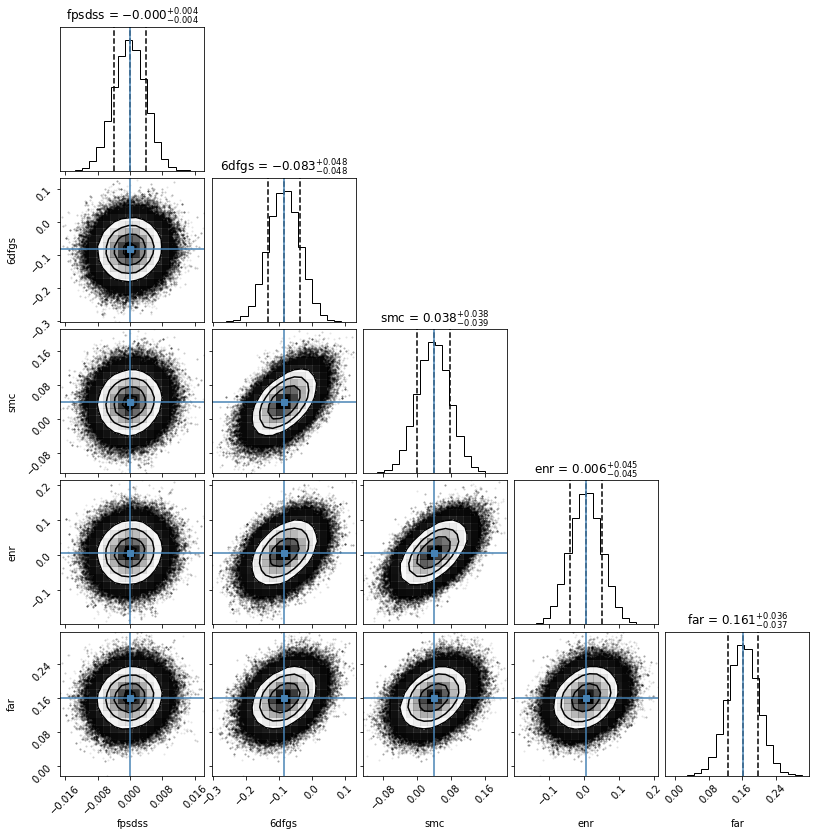

In [81]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 64

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [82]:
npzName = "CF4_FP_group.221027.erratum.npz"
np.savez(npzName, samples)

In [83]:
npzName = "CF4_FP_group.221027.erratum.npz"
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

npz attributes:  ['arr_0']


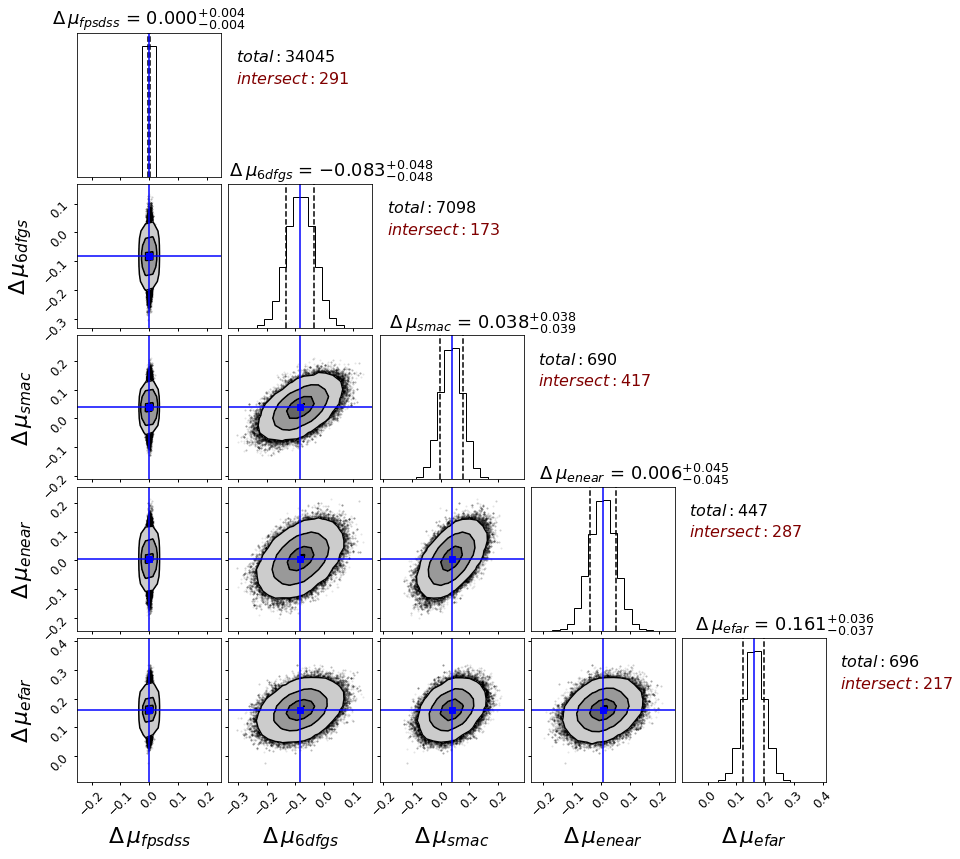

In [84]:
theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]

labels = ['           '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in ["fpsdss", "6dfgs", "smac", "enear", "efar"]]

fig = corner.corner(samples, labels=labels, 
                    truths=truths, truth_color='blue',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 18}, 
                    title_fmt=".3f",
                    range=[(t-0.25,t+0.25) for t in truths]
                   )


m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    ### forcing the the title of the upper left corner panel to be zero
    title = ax.get_title().strip()
    if m==0:
        tl = title.split("=")
        left = tl[0]
        right = tl[1]
        nl = right.split("_")
        number = nl[0]
        error  = nl[1]
        title = left+'='+' ${0.000}_'+error
        ax.set_title(title)
        ax.title.set_fontsize(18)

    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()       
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

